In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data.dataloader import DataLoader

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import pickle

from utils import mlp,train_test_model
from utils.scp_utils.ToyExampleSCP import SCP
from utils.scp_utils.ToyExampleSCP import FullSCP, LowRankSCP, BlockDiagonalSCP
from utils.scp_utils.ToyExampleSCP import SketchSCP

from data.sequential_lines import Lines

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


## Get Configurations

In [3]:
n_samples=1000
epochs = 250
lr = 1e-3
batch_size = 100
input_size = 2
hidden_sizes = [128,64]
output_size = 2

seed = 4

num_task = 5

activation='ReLU'
slope=.1
device='cuda:0'

scp_alpha = 0.5
num_sketches = 50
n_slices=10

save_plot = False

gain={
    'Sigmoid':1.,
    'TanH':1.,
    'ReLU':np.sqrt(2.),
    'leakyReLU':np.sqrt(2./(1.+slope**2))
}

In [4]:
def weights_init(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):        
        torch.nn.init.xavier_uniform_(m.weight,gain=gain[activation])
        if m.bias: 
            torch.nn.init.xavier_uniform_(m.bias,gain=gain[activation])

## Load Dataset

In [5]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
datagen = Lines(max_iter=num_task, num_samples=n_samples)
train_loader,test_loader=datagen.get_sequential_lines(n_task=num_task,batch_size=batch_size)

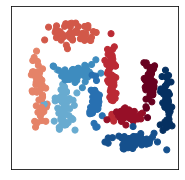

In [6]:
fig, ax = plt.subplots(1,1,figsize=(3,3))
sample_list = []
label_list = []
for i in range(num_task):
    iter_data=iter(train_loader[i])
    sample,label=iter_data.next()
    sample_list.append(sample)
    label_list.append((label-0.5)*(4+i))
sample_list = torch.cat(sample_list)
label_list = torch.cat(label_list)
ax.scatter(sample_list[:,0],sample_list[:,1],c=label_list,cmap='RdBu')
ax.set_xlim([-0.5,2.5])
ax.set_ylim([-0.75,1.25])
ax.set_xticks([])
ax.set_yticks([])
plt.show()

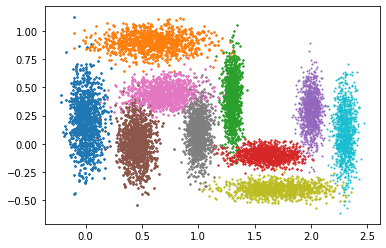

In [7]:
color = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
plt.figure()
for tid in range(num_task):
    for l in range(tid+1):
        idx = np.where(datagen.y == l)
        plt.scatter(datagen.X[idx][:,0], datagen.X[idx][:,1], c=color[l], s=1)
        idx = np.where(datagen.y == l+datagen.offset)
        plt.scatter(datagen.X[idx][:,0], datagen.X[idx][:,1], c=color[l+datagen.offset], s=1)

In [8]:
X,Y=torch.meshgrid(torch.linspace(-0.5,2.5,150),torch.linspace(-0.75,1.25,100))
grid=torch.stack([X.reshape(-1),Y.reshape(-1)]).T

## Test SCP

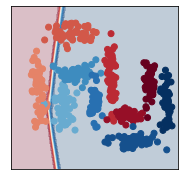

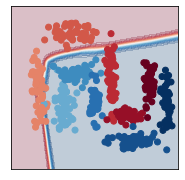

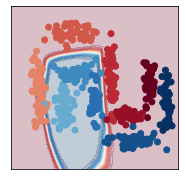

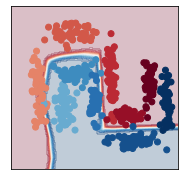

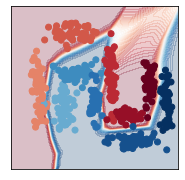

In [9]:
scp_importance=1e+4

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## define a MLP model
model=mlp.MLP(input_size=input_size,output_size=output_size,
              hidden_size=hidden_sizes,activation=activation,
              require_bias=True,device=device).to(device)
# model.apply(weights_init)
scp= SCP(model,device=device,alpha=scp_alpha,n_slices=n_slices)

## performing training
loss_scp, acc_scp = {}, {}
for task in tqdm(range(num_task)):
    loss_scp[task] = []
    acc_scp[task] = []
    for _ in tqdm(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss_scp[task].append(train_test_model.scp_train_classifier(scp=scp,
                                                                      optimizer=optimizer,
                                                                      data_loader=train_loader[task],
                                                                      importance=scp_importance,
                                                                      device=device))                           
        for sub_task in range(task + 1):
            acc_scp[sub_task].append(train_test_model.test_classifier(model=scp.model,
                                                                 data_loader=test_loader[sub_task],
                                                                 device=device))        
    scp.consolidate(train_loader[task])    
    importance_SCP=list()
    for i,n in enumerate(scp._precision_matrices.keys()):
        importance_SCP.append(scp._precision_matrices[n].detach().cpu().numpy())
    
    plt.figure(figsize=(3,3))
    # Plot decision boundary
    pred=nn.Softmax(-1)(model(grid.to(device)))[:,1].reshape(150,100).detach().cpu().numpy()
    plt.contourf(X, Y, pred,cmap='RdBu', alpha=0.25,levels=50)
    # Plot data
    plt.scatter(sample_list[:,0],sample_list[:,1],c=label_list,cmap='RdBu')
    plt.xlim([-0.5,2.5])
    plt.ylim([-0.75,1.25])
    plt.xticks([])
    plt.yticks([])
    if save_plot: plt.savefig("figure/toy_scp_task_%d.pdf"%(task+1), bbox_inches='tight')
    plt.show()


Text(0.5, 0.98, 'Using SCP Regularizer')

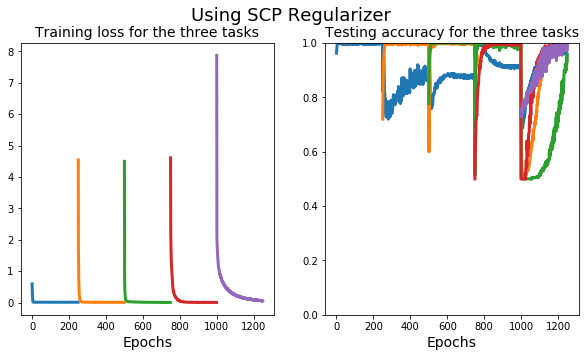

In [11]:
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss_scp.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for the three tasks',fontsize=14)
for t, v in acc_scp.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for the three tasks',fontsize=14)
fig.suptitle('Using SCP Regularizer',fontsize=18)

## Test SketchSCP

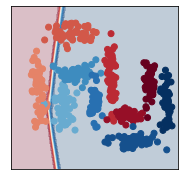

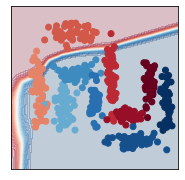

KeyboardInterrupt: 

In [22]:
sketch_scp_importance=1

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## define a MLP model
model=mlp.MLP(input_size=input_size,output_size=output_size,
              hidden_size=hidden_sizes,activation=activation,
              require_bias=True,device=device).to(device)
# model.apply(weights_init)
sketch_scp= SketchSCP(model,device=device,alpha=scp_alpha,n_bucket=num_sketches,n_slices=n_slices)

## performing training
loss_sketch_scp, acc_sketch_scp = {}, {}
for task in tqdm(range(num_task)):
    loss_sketch_scp[task] = []
    acc_sketch_scp[task] = []
    for _ in tqdm(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss_sketch_scp[task].append(train_test_model.scp_train_classifier(scp=sketch_scp,
                                                                      optimizer=optimizer,
                                                                      data_loader=train_loader[task],
                                                                      importance=sketch_scp_importance,
                                                                      device=device))                           
        for sub_task in range(task + 1):
            acc_sketch_scp[sub_task].append(train_test_model.test_classifier(model=sketch_scp.model,
                                                                 data_loader=test_loader[sub_task],
                                                                 device=device)) 
    sketch_scp.consolidate(train_loader[task])    
    
    plt.figure(figsize=(3,3))
    # Plot decision boundary
    pred=nn.Softmax(-1)(model(grid.to(device)))[:,1].reshape(150,100).detach().cpu().numpy()
    plt.contourf(X, Y, pred,cmap='RdBu', alpha=0.25,levels=50)
    # Plot data
    plt.scatter(sample_list[:,0],sample_list[:,1],c=label_list,cmap='RdBu')
    plt.xlim([-0.5,2.5])
    plt.ylim([-0.75,1.25])
    plt.xticks([])
    plt.yticks([])
    if save_plot: plt.savefig("figure/toy_sketch_scp_task_%d.pdf"%(task+1), bbox_inches='tight')
    plt.show()            


Text(0.5, 0.98, 'Using SketchSCP Regularizer')

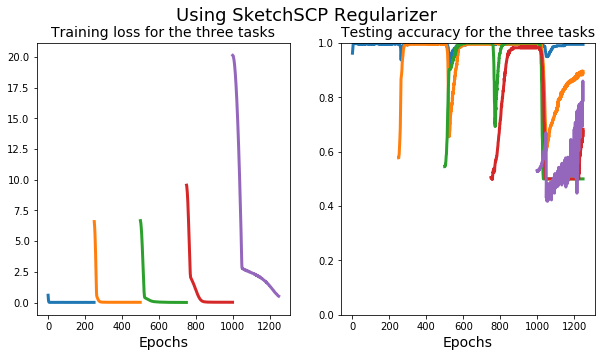

In [21]:
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss_sketch_scp.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for the three tasks',fontsize=14)
for t, v in acc_sketch_scp.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for the three tasks',fontsize=14)
fig.suptitle('Using SketchSCP Regularizer',fontsize=18)

## Full Hessian SCP (FIM)

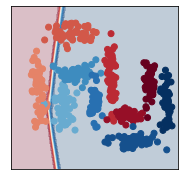

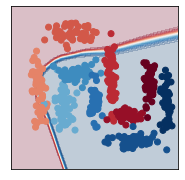

KeyboardInterrupt: 

In [17]:
full_scp_importance=1

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## define a MLP model
model=mlp.MLP(input_size=input_size,output_size=output_size,
              hidden_size=hidden_sizes,activation=activation,
              require_bias=True,device=device).to(device)
# model.apply(weights_init)
full_scp= FullSCP(model,device=device,alpha=scp_alpha)

## performing training
loss_full_scp, acc_full_scp = {}, {}
for task in tqdm(range(num_task)):
    loss_full_scp[task] = []
    acc_full_scp[task] = []
    for _ in tqdm(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss_full_scp[task].append(train_test_model.scp_train_classifier(scp=full_scp,
                                                                      optimizer=optimizer,
                                                                      data_loader=train_loader[task],
                                                                      importance=full_scp_importance,
                                                                      device=device))                           
        for sub_task in range(task + 1):
            acc_full_scp[sub_task].append(train_test_model.test_classifier(model=full_scp.model,
                                                                 data_loader=test_loader[sub_task],
                                                                 device=device))        
    full_scp.consolidate(train_loader[task])
    
    plt.figure(figsize=(3,3))
    # Plot decision boundary
    pred=nn.Softmax(-1)(model(grid.to(device)))[:,1].reshape(150,100).detach().cpu().numpy()
    plt.contourf(X, Y, pred,cmap='RdBu', alpha=0.25,levels=50)
    # Plot data
    plt.scatter(sample_list[:,0],sample_list[:,1],c=label_list,cmap='RdBu')
    plt.xlim([-0.5,2.5])
    plt.ylim([-0.75,1.25])
    plt.xticks([])
    plt.yticks([])
    if save_plot: plt.savefig("figure/toy_full_scp_task_%d.pdf"%(task+1), bbox_inches='tight')
    plt.show()  


Text(0.5, 0.98, 'Using Full Hessian of MAS Regularizer (FIM)')

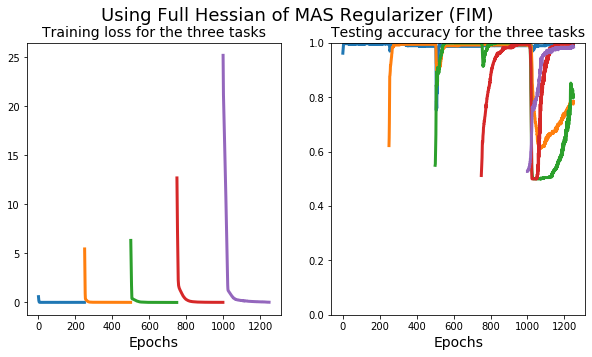

In [14]:
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss_full_scp.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for the three tasks',fontsize=14)
for t, v in acc_full_scp.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for the three tasks',fontsize=14)
fig.suptitle('Using Full Hessian of SCP Regularizer (FIM)',fontsize=18)

## Rank-1 MAS

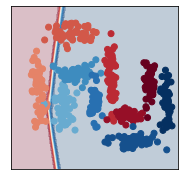

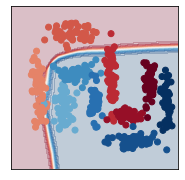

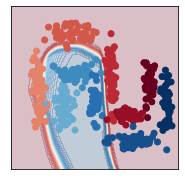

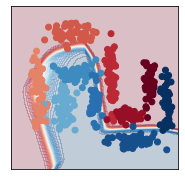

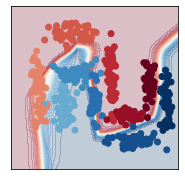

In [15]:
rank_1_mas_importance=1e4

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## define a MLP model
model=mlp.MLP(input_size=input_size,output_size=output_size,
              hidden_size=hidden_sizes,activation=activation,
              require_bias=True,device=device).to(device)
# model.apply(weights_init)
rank_1_mas= LowRankMAS(model,device=device,alpha=mas_alpha,n_bucket=1)

## performing training
loss_rank_1_mas, acc_rank_1_mas = {}, {}
for task in tqdm(range(num_task)):
    loss_rank_1_mas[task] = []
    acc_rank_1_mas[task] = []
    for _ in tqdm(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss_rank_1_mas[task].append(train_test_model.mas_train_classifier(mas=rank_1_mas,
                                                                      optimizer=optimizer,
                                                                      data_loader=train_loader[task],
                                                                      importance=rank_1_mas_importance,
                                                                      device=device))                           
        for sub_task in range(task + 1):
            acc_rank_1_mas[sub_task].append(train_test_model.test_classifier(model=rank_1_mas.model,
                                                                 data_loader=test_loader[sub_task],
                                                                 device=device))        
    rank_1_mas.consolidate(train_loader[task])
    
    plt.figure(figsize=(3,3))
    # Plot decision boundary
    pred=nn.Softmax(-1)(model(grid.to(device)))[:,1].reshape(150,100).detach().cpu().numpy()
    plt.contourf(X, Y, pred,cmap='RdBu', alpha=0.25,levels=50)
    # Plot data
    plt.scatter(sample_list[:,0],sample_list[:,1],c=label_list,cmap='RdBu')
    plt.xlim([-0.5,2.5])
    plt.ylim([-0.75,1.25])
    plt.xticks([])
    plt.yticks([])
    if save_plot: plt.savefig("figure/toy_rank_1_mas_task_%d.pdf"%(task+1), bbox_inches='tight')
    plt.show()  


Text(0.5, 0.98, 'Using Rank-1 Hessian of MAS Regularizer')

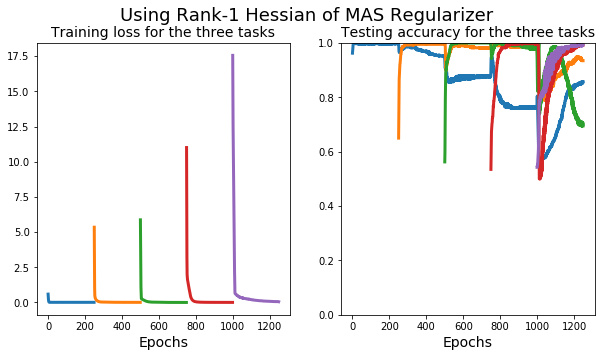

In [16]:
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss_rank_1_mas.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for the three tasks',fontsize=14)
for t, v in acc_rank_1_mas.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for the three tasks',fontsize=14)
fig.suptitle('Using Rank-1 Hessian of MAS Regularizer',fontsize=18)

## Low Rank MAS

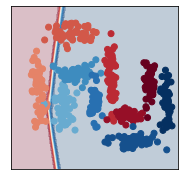

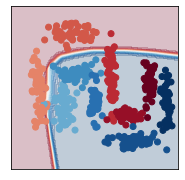

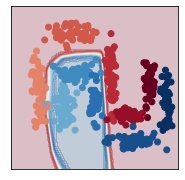

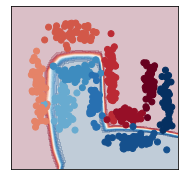

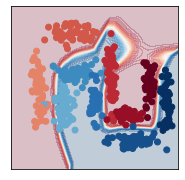

In [17]:
low_rank_mas_importance=1e4

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## define a MLP model
model=mlp.MLP(input_size=input_size,output_size=output_size,
              hidden_size=hidden_sizes,activation=activation,
              require_bias=True,device=device).to(device)
# model.apply(weights_init)
low_rank_mas= LowRankMAS(model,device=device,alpha=mas_alpha,n_bucket=num_sketches)

## performing training
loss_low_rank_mas, acc_low_rank_mas = {}, {}
for task in tqdm(range(num_task)):
    loss_low_rank_mas[task] = []
    acc_low_rank_mas[task] = []
    for _ in tqdm(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss_low_rank_mas[task].append(train_test_model.mas_train_classifier(mas=low_rank_mas,
                                                                      optimizer=optimizer,
                                                                      data_loader=train_loader[task],
                                                                      importance=low_rank_mas_importance,
                                                                      device=device))                           
        for sub_task in range(task + 1):
            acc_low_rank_mas[sub_task].append(train_test_model.test_classifier(model=low_rank_mas.model,
                                                                 data_loader=test_loader[sub_task],
                                                                 device=device))        
    low_rank_mas.consolidate(train_loader[task])
    
    plt.figure(figsize=(3,3))
    # Plot decision boundary
    pred=nn.Softmax(-1)(model(grid.to(device)))[:,1].reshape(150,100).detach().cpu().numpy()
    plt.contourf(X, Y, pred,cmap='RdBu', alpha=0.25,levels=50)
    # Plot data
    plt.scatter(sample_list[:,0],sample_list[:,1],c=label_list,cmap='RdBu')
    plt.xlim([-0.5,2.5])
    plt.ylim([-0.75,1.25])
    plt.xticks([])
    plt.yticks([])
    if save_plot: plt.savefig("figure/toy_low_rank_mas_task_%d.pdf"%(task+1), bbox_inches='tight')
    plt.show()           


Text(0.5, 0.98, 'Using Low Rank Hessian of MAS Regularizer')

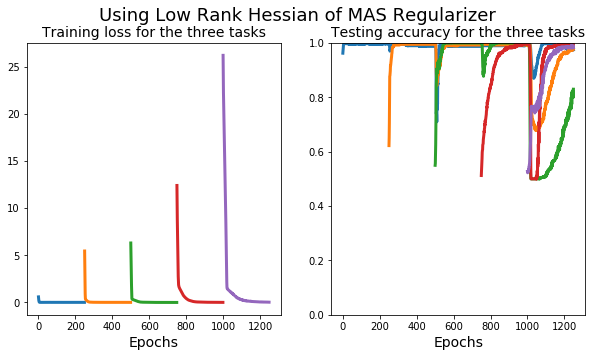

In [18]:
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss_low_rank_mas.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for the three tasks',fontsize=14)
for t, v in acc_low_rank_mas.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for the three tasks',fontsize=14)
fig.suptitle('Using Low Rank Hessian of MAS Regularizer',fontsize=18)

## Block Diagonal MAS

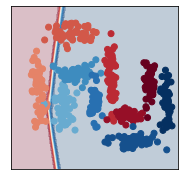

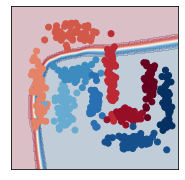

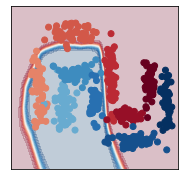

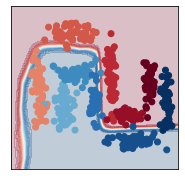

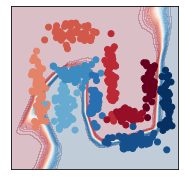

In [21]:
block_diagonal_mas_importance=1e+4

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## define a MLP model
model=mlp.MLP(input_size=input_size,output_size=output_size,
              hidden_size=hidden_sizes,activation=activation,
              require_bias=True,device=device).to(device)
# model.apply(weights_init)
block_diagonal_mas= BlockDiagonalMAS(model,device=device,alpha=mas_alpha,n_bucket=50)

## performing training
loss_block_diagonal_mas, acc_block_diagonal_mas = {}, {}
for task in tqdm(range(num_task)):
    loss_block_diagonal_mas[task] = []
    acc_block_diagonal_mas[task] = []
    for _ in tqdm(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss_block_diagonal_mas[task].append(train_test_model.mas_train_classifier(mas=block_diagonal_mas,
                                                                      optimizer=optimizer,
                                                                      data_loader=train_loader[task],
                                                                      importance=block_diagonal_mas_importance,
                                                                      device=device))                           
        for sub_task in range(task + 1):
            acc_block_diagonal_mas[sub_task].append(train_test_model.test_classifier(model=block_diagonal_mas.model,
                                                                 data_loader=test_loader[sub_task],
                                                                 device=device))        
    block_diagonal_mas.consolidate(train_loader[task])
    
    plt.figure(figsize=(3,3))
    # Plot decision boundary
    pred=nn.Softmax(-1)(model(grid.to(device)))[:,1].reshape(150,100).detach().cpu().numpy()
    plt.contourf(X, Y, pred,cmap='RdBu', alpha=0.25,levels=50)
    # Plot data
    plt.scatter(sample_list[:,0],sample_list[:,1],c=label_list,cmap='RdBu')
    plt.xlim([-0.5,2.5])
    plt.ylim([-0.75,1.25])
    plt.xticks([])
    plt.yticks([])
    if save_plot: plt.savefig("figure/toy_block_diagonal_mas_task_%d.pdf"%(task+1), bbox_inches='tight')
    plt.show()


Text(0.5, 0.98, 'Using Block Diagonal Hessian of MAS Regularizer')

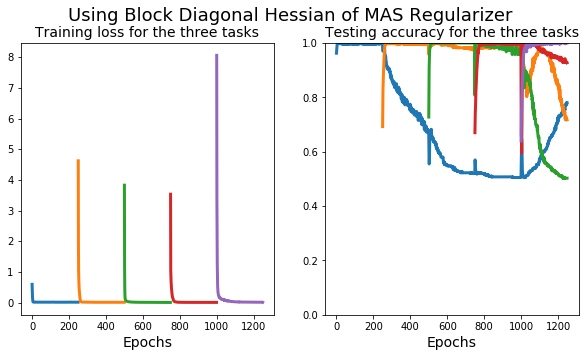

In [22]:
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss_block_diagonal_mas.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for the three tasks',fontsize=14)
for t, v in acc_block_diagonal_mas.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for the three tasks',fontsize=14)
fig.suptitle('Using Block Diagonal Hessian of MAS Regularizer',fontsize=18)

In [23]:
def get_mean_acc(acc,epochs):
    num_task=len(acc)
    temp=np.zeros((num_task,len(acc[0])))
    for t,v in acc.items():
        temp[t,range(t * epochs, num_task * epochs)]=v
        if t<num_task-1:
            temp[t+1,:]=temp[:t+1,:].mean(0)
    return temp.mean(0)

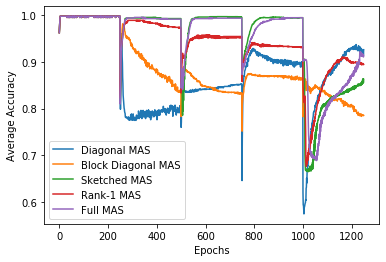

In [24]:
plt.plot(get_mean_acc(acc_mas,epochs))
plt.plot(get_mean_acc(acc_block_diagonal_mas,epochs))
plt.plot(get_mean_acc(acc_sketch_mas,epochs))
plt.plot(get_mean_acc(acc_rank_1_mas,epochs))
plt.plot(get_mean_acc(acc_full_mas,epochs))
# plt.title('Mean Accuracy Comparison')
plt.xlabel('Epochs'),plt.ylabel('Average Accuracy')
plt.legend(['Diagonal MAS','Block Diagonal MAS','Sketched MAS','Rank-1 MAS','Full MAS'])
# plt.savefig("figure/toy_mas_accuracy.pdf", bbox_inches='tight')

In [25]:
print(get_mean_acc(acc_mas,epochs)[-1],
      get_mean_acc(acc_block_diagonal_mas,epochs)[-1],
      get_mean_acc(acc_sketch_mas,epochs)[-1],
      get_mean_acc(acc_rank_1_mas,epochs)[-1],
      get_mean_acc(acc_low_rank_mas,epochs)[-1],
      get_mean_acc(acc_full_mas,epochs)[-1])

0.9259999999999999 0.7855000000000001 0.8625 0.8945000000000001 0.9520000000000002 0.913


In [26]:
results_folder = 'toy_example/'
pickle.dump([acc_mas, acc_block_diagonal_mas, acc_sketch_mas, acc_rank_1_mas, acc_low_rank_mas, acc_full_mas], open(results_folder+'toy_example_mas_id_%d.pkl'%(seed),'wb'))